# Two Fundamental Factor Model

In [2]:
# -*- coding: utf-8 -*-
"""
Two Fundamental Factors
"""

%matplotlib inline
import numpy as np
from scipy.io import loadmat
import pandas as pd
import functions as fn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
#pd.set_option('display.max_rows', 16)

matP = loadmat('inputData_SPX_200401_201312Select.mat', variable_names=['tday', 'syms', 'bid', 'ask'])
mat1 = loadmat('fundamentalDataSelect.mat', variable_names=['tday', 'syms', 'ARQ_PB'])
mat2 = loadmat('fundamentalsSelect.mat', variable_names=["ARQ_EPS","ARQ_BVPS"])

symsP = [e[0] for e in matP.pop('syms').squeeze()]
syms1 = [e[0] for e in mat1.pop('syms').squeeze()]

dates1 = pd.DatetimeIndex(mat1.pop('tday').astype(str).squeeze())
datesP = pd.DatetimeIndex(matP.pop('tday').astype(str).squeeze())

assert(symsP==syms1)
assert(all(dates1==datesP))

mid = pd.DataFrame((matP['bid'] + matP['ask']) / 2)

Ret1 = fn.calculateReturns(mid.copy(), 1)

# hold for 21 days (1 month)
holdingDays = 21

# monthly return
RetM = fn.calculateReturns(mid.copy(), holdingDays)
del matP

# shifted next quarter's return to today's row to use as response variable.
# Can enter only at next day's close.
RetFut = RetM.copy().shift(-(holdingDays+1))

del RetM, mid

#############################
m = RetFut.shape[0]
trainSize = m // 2
testSize = m - trainSize
#############################

RetFutTrain = RetFut.iloc[:trainSize]
RetFutTest = RetFut.iloc[trainSize:]
Ret1train = Ret1.iloc[:trainSize]
Ret1test = Ret1.iloc[trainSize:]

#flattening and repetition of the date vector
flat_train = RetFutTrain.size
flat_test = RetFutTest.size
m0 = RetFut.shape[0] #original number of observations
nStocks = len(syms1) #original number of stocks

datesTrain = dates1.to_numpy()[:trainSize].flatten()
datesTest = dates1.to_numpy()[trainSize:].flatten()

del dates1, datesP, RetFut

# Combine different independent variables into one matrix X for training
Xtrain = np.nan * np.empty((trainSize * len(symsP), 2))
Xtest = np.nan * np.empty((testSize * len(symsP), 2))

# dependent variable
Ytrain = RetFutTrain.to_numpy().flatten()[:,np.newaxis]
Ytest = RetFutTest.to_numpy().flatten()[:,np.newaxis]

# Earnings (net income) per Basic Share
earningsInc = pd.DataFrame(mat2.pop('ARQ_EPS'))
bvpershr = pd.DataFrame(mat2.pop('ARQ_BVPS'))

bvpershr_lag = bvpershr.ffill().shift(1)

del mat2

ROE = 1 + earningsInc.divide(bvpershr_lag)
ROE.fillna(value=-99.5, inplace=True)
ROE[ROE <= 0] = np.nan

BM = 1 / pd.DataFrame(mat1.pop('ARQ_PB'))
BM.fillna(value=-99.5, inplace=True)
BM[BM <= 0] = np.nan

del mat1

Xtrain[:,0] = np.log(BM.iloc[:trainSize].to_numpy()).flatten()
Xtrain[:,1] = np.log(ROE.iloc[:trainSize].to_numpy()).flatten()

Xtest[:,0] = np.log(BM.iloc[trainSize:].to_numpy()).flatten()
Xtest[:,1] = np.log(ROE.iloc[trainSize:].to_numpy()).flatten()

XYtrain = pd.DataFrame(np.hstack([Xtrain, Ytrain])).dropna(how='any', axis=0)
XYtest = pd.DataFrame(np.hstack([Xtest, Ytest])).dropna(how='any', axis=0)

ixCleanTrain = XYtrain.index.to_numpy()
ixCleanTest = XYtest.index.to_numpy()

XYtrain = XYtrain.to_numpy()
XYtest = XYtest.to_numpy()

Xtrain, ytrain = XYtrain[:, 0:-1], XYtrain[:, -1][:,np.newaxis]
Xtest, ytest = XYtest[:, 0:-1], XYtest[:, -1][:,np.newaxis]

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn import linear_model
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.cross_validation import KFold
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error
import numpy as np

C:\Users\sendn\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
resultDF = pd.DataFrame(columns=['model','hyperparams','train_acc','train_std','test_acc','test_std'])
df_idx = 0

In [5]:
def crossValidate(typ, model, X, Y, hyperparams='default'):
    
    global df_idx
    
    # Update model hyperparameters if given
    if hyperparams is not 'default':
        model.set_params(**hyperparams)
        
    kf = KFold(len(X),n_folds=10) #n_splits previously n_folds
    
    outcomes = []
    outcomes_train=[]
    fold = 0
    
    for train_index, valid_index in kf:
        fold += 1
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        Y_train, Y_valid = Y.iloc[train_index], Y.iloc[valid_index]
        
        
        model.fit(X_train, Y_train)
        predictions = model.predict(X_valid)
        predictions_train=model.predict(X_train)
        accuracy = r2_score(Y_valid, predictions) 
        accuracy_train = r2_score(Y_train, predictions_train) 

        outcomes.append(accuracy)
        outcomes_train.append(accuracy_train)
        print("Fold {0} Training accuracy: {1}".format(fold, accuracy_train))   
        print("Fold {0} Validation accuracy: {1}".format(fold, accuracy))   
    mean_outcome = np.mean(outcomes)
    std_outcome=np.std(outcomes)
    mean_outcome_train=np.mean(outcomes_train)
    std_outcome_train=np.std(outcomes_train)
    print('\n')
    print("Mean r2 score for Validation data: {0}".format(mean_outcome)) 
    print("Standard Deviation for Validation data: {0}".format(std_outcome))
    print('\n')

     # Update dataframe
    resultDF.loc[df_idx, 'model'] = typ
    resultDF.loc[df_idx, 'hyperparams'] = str(hyperparams)
    resultDF.loc[df_idx, 'train_acc'] = mean_outcome_train
    resultDF.loc[df_idx, 'train_std'] = std_outcome_train
    resultDF.loc[df_idx, 'test_acc'] = mean_outcome
    resultDF.loc[df_idx, 'test_std'] = std_outcome
    df_idx += 1

In [6]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Lasso Regression': linear_model.Lasso(),
    'Ada Boosting': AdaBoostRegressor(),
    'Bagging Regressor': BaggingRegressor(),
    'Extra Tree Regressor': ExtraTreesRegressor()
}

In [7]:
for name, m in models.items():
    print ("Fitting " + name + " model \n")
    crossValidate(name, m, pd.DataFrame(Xtrain), pd.DataFrame(ytrain), 'default')

Fitting Linear Regression model 

Fold 1 Training accuracy: 0.012467323172402733
Fold 1 Validation accuracy: -0.026016774197000103
Fold 2 Training accuracy: 0.013583931141298855
Fold 2 Validation accuracy: -0.06526961482216898
Fold 3 Training accuracy: 0.015479793129442254
Fold 3 Validation accuracy: -0.019811025350835676
Fold 4 Training accuracy: 0.01616244264055855
Fold 4 Validation accuracy: -0.1035698591622567
Fold 5 Training accuracy: 0.019817509077642126
Fold 5 Validation accuracy: -0.4941120458382222
Fold 6 Training accuracy: 0.0003201829468735262
Fold 6 Validation accuracy: -0.1344719682423976
Fold 7 Training accuracy: 0.011738584537454466
Fold 7 Validation accuracy: -0.1446226016664489
Fold 8 Training accuracy: 0.011325407464850779
Fold 8 Validation accuracy: -0.2330043718917958
Fold 9 Training accuracy: 0.012897404220351572
Fold 9 Validation accuracy: -0.2964316667437312
Fold 10 Training accuracy: 0.01430300975732135
Fold 10 Validation accuracy: -0.507085911907923


Mean r2 s

Fold 10 Training accuracy: 0.9999999948636833
Fold 10 Validation accuracy: -0.8777627267721388


Mean r2 score for Validation data: -0.703132695885278
Standard Deviation for Validation data: 0.33868181959704174




In [8]:
resultDF = resultDF.sort_values('test_acc',ascending=False)#.reset_index(drop=True)
resultDF.groupby('model').first().sort_values('test_acc',ascending=False)

,hyperparams,train_acc,train_std,test_acc,test_std
model,,,,,
Lasso Regression,default,0.000000,0.000000e+00,-0.186767,0.169079
Linear Regression,default,0.012810,4.793458e-03,-0.202440,0.169907
Gradient Boosting,default,0.226137,2.616019e-02,-0.252752,0.206151
Ada Boosting,default,0.148254,2.255426e-02,-0.342405,0.471287
Bagging Regressor,default,0.790799,1.501009e-02,-0.587662,0.250184
Random Forest,default,0.791347,1.019203e-02,-0.613170,0.264846
Extra Tree Regressor,default,1.000000,7.783210e-10,-0.703133,0.338682
Decision Tree,default,1.000000,5.632985e-09,-2.188673,1.215109


In [9]:
param_grids = {}
param_grids['Linear Regression'] = {'normalize': [True, False]}
param_grids['Decision Tree'] = {
                      'max_features': ['auto','sqrt','log2'],
                      'max_depth': [int(x) for x in np.arange(1,5)] + [None]
                                }
param_grids['Random Forest'] = {'n_estimators': [int(x) for x in np.arange(10,50,10)],
                      'max_features': ['auto','sqrt','log2'],
                      'max_depth': [int(x) for x in np.arange(1,5)] + [None],
                      'bootstrap': [True,False]
                                }
param_grids['Gradient Boosting'] =  {'n_estimators': [int(x) for x in np.arange(100,500,100)],
                      'max_features': ['auto','sqrt','log2'],
                      'max_depth': [int(x) for x in np.arange(1,5)],
                      'alpha': [0.7, 0.8, 0.9],
                    'learning_rate': [0.05,0.1,0.5,1],
                                      }
param_grids['Lasso Regression'] = {'alpha': [0.7, 0.8, 0.9],
                                    "normalize": [True, False]
                                  }
param_grids['Ada Boosting'] =  {'n_estimators': [int(x) for x in np.arange(50,500,100)],
                    'learning_rate': [0.05,0.1,0.5,1],
                                }
param_grids['Bagging Regressor'] =  {'n_estimators': [int(x) for x in np.arange(10,50,10)],
                      'bootstrap': [True,False],
                                      }
param_grids['Extra Tree Regressor'] =  {'n_estimators': [int(x) for x in np.arange(10,50,10)],
                      'bootstrap': [True,False],
                                      }

In [10]:
df_idx = 0

In [11]:
def gridSearch(name, models, param_grids, X, Y):
    # Get model and param grid
    model = models[name]
    current_param_grid = param_grids[name]
    print ("Fitting " + name + " model \n")
    
    random = GridSearchCV(estimator = model, 
                               param_grid = current_param_grid
                               )
    # Fit the model to find the best hyperparameter values
    random.fit(X, Y)
    
    params=random.best_params_
    # Cross validate model with selected hyperparams using the function we generated earlier
    crossValidate(name, model, X, Y, params)

In [12]:
for name in models.keys():
    gridSearch(name, models, param_grids, pd.DataFrame(Xtrain), pd.DataFrame(ytrain))

Fitting Linear Regression model 

Fold 1 Training accuracy: 0.012467323172402733
Fold 1 Validation accuracy: -0.026016774197000103
Fold 2 Training accuracy: 0.013583931141298855
Fold 2 Validation accuracy: -0.0652696148221692
Fold 3 Training accuracy: 0.015479793129442254
Fold 3 Validation accuracy: -0.019811025350835676
Fold 4 Training accuracy: 0.01616244264055855
Fold 4 Validation accuracy: -0.1035698591622567
Fold 5 Training accuracy: 0.019817509077642126
Fold 5 Validation accuracy: -0.4941120458382222
Fold 6 Training accuracy: 0.0003201829468735262
Fold 6 Validation accuracy: -0.1344719682423976
Fold 7 Training accuracy: 0.011738584537454466
Fold 7 Validation accuracy: -0.14462260166644914
Fold 8 Training accuracy: 0.011325407464850779
Fold 8 Validation accuracy: -0.2330043718917958
Fold 9 Training accuracy: 0.012897404220351572
Fold 9 Validation accuracy: -0.2964316667437312
Fold 10 Training accuracy: 0.01430300975732135
Fold 10 Validation accuracy: -0.5070859119079227


Mean r2 

Fold 8 Training accuracy: 0.8393239590444135
Fold 8 Validation accuracy: -0.5325519844713891
Fold 9 Training accuracy: 0.8334969355394718
Fold 9 Validation accuracy: -0.800691321250133
Fold 10 Training accuracy: 0.8445340179510413
Fold 10 Validation accuracy: -0.6830646590737461


Mean r2 score for Validation data: -0.4483734462276983
Standard Deviation for Validation data: 0.20878430913390641




In [13]:
resultDF = resultDF.sort_values('test_acc',ascending=False)#.reset_index(drop=True)
resultDF.groupby('model').first().sort_values('test_acc',ascending=False)

,hyperparams,train_acc,train_std,test_acc,test_std
model,,,,,
Random Forest,"{'bootstrap': True, 'max_depth': 1, 'max_featu...",0.043603,0.013241,-0.183278,0.171279
Lasso Regression,"{'alpha': 0.7, 'normalize': True}",0.000000,0.000000,-0.186767,0.169079
Linear Regression,{'normalize': True},0.012810,0.004793,-0.202440,0.169907
Gradient Boosting,"{'alpha': 0.8, 'learning_rate': 0.05, 'max_dep...",0.070917,0.020987,-0.203755,0.178670
Decision Tree,"{'max_depth': 3, 'max_features': 'auto'}",0.083544,0.024196,-0.215793,0.184418
Ada Boosting,"{'learning_rate': 0.1, 'n_estimators': 50}",0.152807,0.024481,-0.219324,0.195458
Extra Tree Regressor,"{'bootstrap': True, 'n_estimators': 40}",0.834768,0.007022,-0.448373,0.208784
Bagging Regressor,"{'bootstrap': True, 'n_estimators': 40}",0.833290,0.005871,-0.478372,0.238638


In [14]:
n_estimators=np.arange(10,12500,1000)
trainErr = np.zeros(n_estimators.shape)
testErr = np.zeros(n_estimators.shape)
trainAcc = np.zeros(n_estimators.shape)
testAcc = np.zeros(n_estimators.shape)
    
for c,i in enumerate(n_estimators):
    model = GradientBoostingRegressor(n_estimators= i)

    # Train model
    model.fit(Xtrain, ytrain)
    
    # Make Predictions
    y_train_pred = model.predict(Xtrain)
    y_test_pred = model.predict(Xtest)
    
    # Calculate Error
    trainErr[c] = mean_squared_error(ytrain, y_train_pred)
    testErr[c] = mean_squared_error(ytest, y_test_pred)

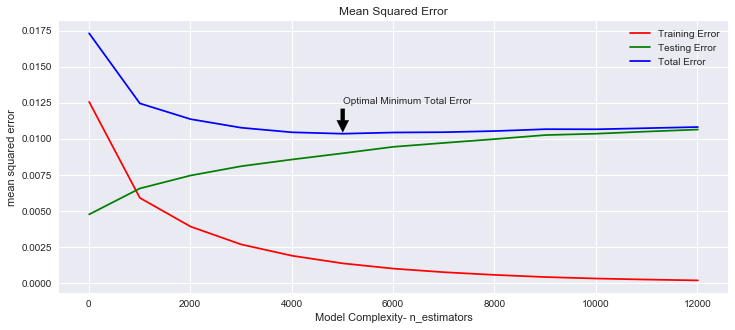

In [33]:
plt.figure(figsize=(12,5))
totalErr= trainErr + testErr

plt.plot(n_estimators, trainErr,'r',label='Training Error')
plt.plot(n_estimators, testErr,'g',label='Testing Error')
plt.plot(n_estimators, trainErr + testErr, 'b', label='Total Error')
ymin=np.amin(totalErr)
pos = np.where(totalErr == ymin)[0]
xmin=n_estimators[pos[0]]
plt.annotate('Optimal Minimum Total Error', xy=(xmin, ymin), xytext=(xmin, ymin+0.0021),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.title("Mean Squared Error")
plt.xlabel("Model Complexity- n_estimators")
plt.ylabel("mean squared error")
plt.legend(loc=1)
#plt.xlim(1,n_estimators[-2])

In [34]:
tradingDF = pd.DataFrame(columns=['model','In_CAGR','In_Sharpe_Ratio','In_maxDD','In_maxDDD','In_Calmar_Ratio', 'Out_CAGR','Out_Sharpe_Ratio','Out_maxDD','Out_maxDDD','Out_Calmar_Ratio'])
df_idx=0

In [35]:
def trading(name, model, hyperparams='default'):
    
    global df_idx
    print ("Fitting " + name + " model \n")

    # Update model hyperparameters if given
    if hyperparams is not 'default':
        model.set_params(**hyperparams)
    
    model.fit(Xtrain, ytrain)
    # Make "predictions" based on model on training set, reshape back to original matrix dimensions
    Ypred = model.predict(Xtrain)    
    
    Ypred=Ypred.reshape(5747,1) ######################################################################

    retPred = np.nan * np.empty((flat_train, 1))
    retPred[ixCleanTrain] = Ypred
    retPred = retPred.reshape(RetFutTrain.shape)

    def compare_nan_array(func, a, thresh):
        out = ~np.isnan(a)
        out[out] = func(a[out] , thresh)
        return out

    longs = pd.DataFrame(compare_nan_array(np.greater, retPred, 0).astype(int)).shift(1) #1 day later
    shorts = pd.DataFrame(compare_nan_array(np.less, retPred, 0).astype(int)).shift(1)

    longs.iloc[0] = 0
    shorts.iloc[0] = 0

    positions = np.zeros(retPred.shape)

    for h in range(holdingDays):
        long_lag = longs.shift(h)
        long_lag.fillna(value=0, inplace=True)
        long_lag = long_lag.to_numpy(dtype=bool)

        short_lag = shorts.shift(h)
        short_lag.fillna(value=0, inplace=True)
        short_lag = short_lag.to_numpy(dtype=bool)

        positions[long_lag] += 1
        positions[short_lag] -= 1

    dRetA = np.sum(np.multiply(pd.DataFrame(positions).shift(1).fillna(0).to_numpy().squeeze(), Ret1train.fillna(0).to_numpy()), axis=1)
    dRetB = np.sum(pd.DataFrame(positions).shift(1).abs().to_numpy().squeeze(), axis=1)

    dailyRet = np.divide(dRetA, dRetB, out=np.zeros_like(dRetA), where=dRetB!=0)
    dailyRet[~np.isfinite(dailyRet)] = 0
    cumret = np.cumprod(1 + dailyRet) - 1

    plt.figure(1)
    plt.plot(range(trainSize), cumret)
    plt.title('Linear Regression: In-Sample')
    plt.ylabel('Cumulative Returns')
    plt.xlabel('Days')

    cagr = (1 + cumret[-1]) ** (252 / trainSize) - 1
    maxDD, maxDDD, _ = fn.calculateMaxDD(cumret)
    ratio = (252.0 ** 0.5) * np.mean(dailyRet) / np.std(dailyRet)
    print(('In-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}'\
    ).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD))

    tradingDF.loc[df_idx, 'model'] = name
    tradingDF.loc[df_idx, 'In_CAGR'] = cagr
    tradingDF.loc[df_idx, 'In_Sharpe_Ratio'] = ratio
    tradingDF.loc[df_idx, 'In_maxDD'] = maxDD
    tradingDF.loc[df_idx, 'In_maxDDD'] = maxDDD.astype(int)
    tradingDF.loc[df_idx, 'In_Calmar_Ratio'] = -cagr/maxDD
    
    ##################################################################

    # Make real predictions on test (out-of-sample)
    Ypred = model.predict(Xtest)

    # print(('Root Mean Squared Error = {:.4f}').format(np.sqrt(mean_squared_error(ytest, Ypred))))

    Ypred=Ypred.reshape(6610,1) ######################################################################


    retPred = np.nan * np.empty((RetFutTest.size, 1))
    retPred[ixCleanTest] = Ypred
    retPred = retPred.reshape(RetFutTest.shape)

    longs = pd.DataFrame(compare_nan_array(np.greater, retPred, 0).astype(int)).shift(1) #1 day later
    shorts = pd.DataFrame(compare_nan_array(np.less, retPred, 0).astype(int)).shift(1)

    longs.iloc[0] = 0
    shorts.iloc[0] = 0

    positions = np.zeros(retPred.shape)

    for h in range(holdingDays):
        long_lag = longs.shift(h)
        long_lag.fillna(value=0, inplace=True)
        long_lag = long_lag.to_numpy(dtype=bool)

        short_lag = shorts.shift(h)
        short_lag.fillna(value=0, inplace=True)
        short_lag = short_lag.to_numpy(dtype=bool)

        positions[long_lag] += 1
        positions[short_lag] -= 1

    dRetA = np.sum(np.multiply(pd.DataFrame(positions).shift(1).fillna(0).to_numpy().squeeze(), Ret1test.fillna(0).to_numpy()), axis=1)
    dRetB = np.sum(pd.DataFrame(positions).shift(1).abs().to_numpy().squeeze(), axis=1)

    dailyRet = np.divide(dRetA, dRetB, out=np.zeros_like(dRetA), where=dRetB!=0)
    dailyRet[~np.isfinite(dailyRet)] = 0
    cumret = np.cumprod(1 + dailyRet) - 1

    from pandas.plotting import register_matplotlib_converters
    register_matplotlib_converters()

    plt.figure(2)
    plt.plot(datesTest, cumret)
    plt.title('Linear regression on SPX log(ROE) and log(BM)')
    plt.ylabel('Cumulative Returns')
    plt.xlabel('Date')

    cagr = (1 + cumret[-1]) ** (252 / testSize) - 1
    maxDD, maxDDD, _ = fn.calculateMaxDD(cumret)
    ratio = (252.0 ** 0.5) * np.mean(dailyRet) / np.std(dailyRet)
    print(('Out-of-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}'\
    ).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD))

    # Update dataframe
    tradingDF.loc[df_idx, 'Out_CAGR'] = cagr
    tradingDF.loc[df_idx, 'Out_Sharpe_Ratio'] = ratio
    tradingDF.loc[df_idx, 'Out_maxDD'] = maxDD
    tradingDF.loc[df_idx, 'Out_maxDDD'] = maxDDD.astype(int)
    tradingDF.loc[df_idx, 'Out_Calmar_Ratio'] = -cagr/maxDD
    df_idx += 1
    plt.show()

In [36]:
from ast import literal_eval

Fitting Random Forest model 

In-sample: CAGR=0.00210846 Sharpe ratio=0.16167 maxDD=-0.528619 maxDDD=685 Calmar ratio=0.00398862
Out-of-sample: CAGR=0.250752 Sharpe ratio=1.31507 maxDD=-0.216898 maxDDD=171 Calmar ratio=1.15609


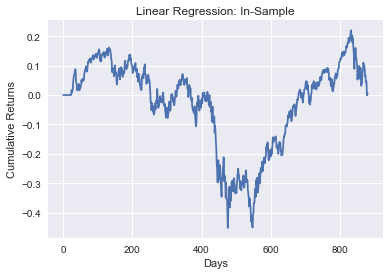

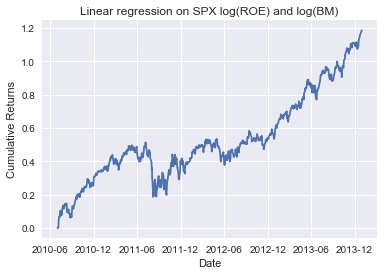

Fitting Lasso Regression model 

In-sample: CAGR=0.00210846 Sharpe ratio=0.16167 maxDD=-0.528619 maxDDD=685 Calmar ratio=0.00398862
Out-of-sample: CAGR=0.250752 Sharpe ratio=1.31507 maxDD=-0.216898 maxDDD=171 Calmar ratio=1.15609


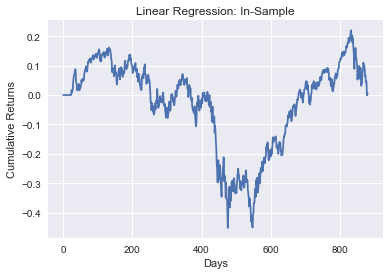

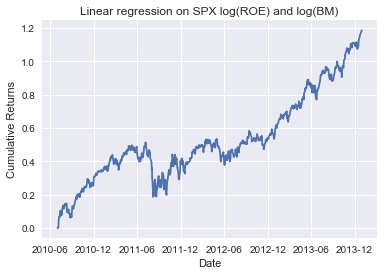

Fitting Linear Regression model 

In-sample: CAGR=0.0495108 Sharpe ratio=0.334931 maxDD=-0.323853 maxDDD=447 Calmar ratio=0.152881
Out-of-sample: CAGR=0.10437 Sharpe ratio=0.982639 maxDD=-0.139648 maxDDD=413 Calmar ratio=0.747375


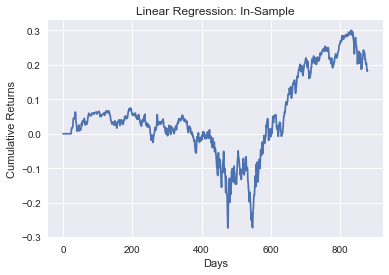

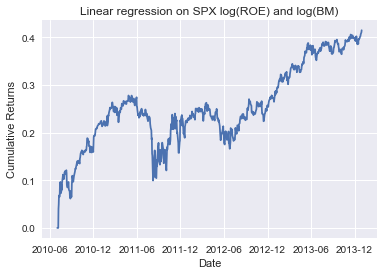

Fitting Gradient Boosting model 

In-sample: CAGR=0.00402664 Sharpe ratio=0.167588 maxDD=-0.525453 maxDDD=685 Calmar ratio=0.00766319
Out-of-sample: CAGR=0.250468 Sharpe ratio=1.31419 maxDD=-0.216898 maxDDD=171 Calmar ratio=1.15477


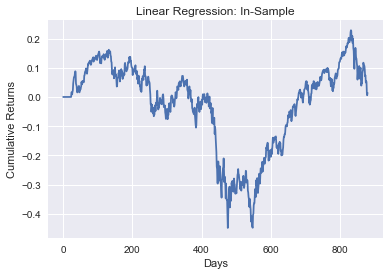

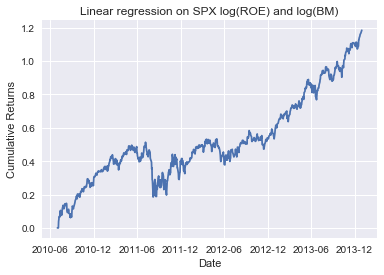

Fitting Decision Tree model 

In-sample: CAGR=0.00210846 Sharpe ratio=0.16167 maxDD=-0.528619 maxDDD=685 Calmar ratio=0.00398862
Out-of-sample: CAGR=0.250752 Sharpe ratio=1.31507 maxDD=-0.216898 maxDDD=171 Calmar ratio=1.15609


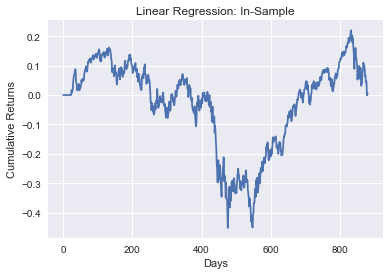

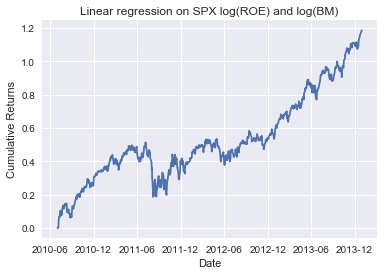

Fitting Ada Boosting model 

In-sample: CAGR=0.00210846 Sharpe ratio=0.16167 maxDD=-0.528619 maxDDD=685 Calmar ratio=0.00398862
Out-of-sample: CAGR=0.250752 Sharpe ratio=1.31507 maxDD=-0.216898 maxDDD=171 Calmar ratio=1.15609


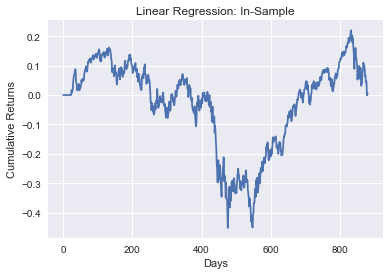

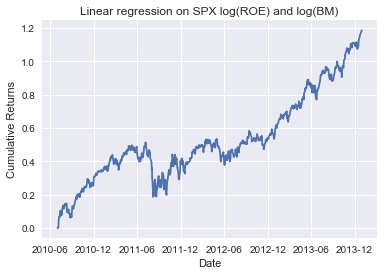

Fitting Extra Tree Regressor model 

In-sample: CAGR=1.53071 Sharpe ratio=5.3234 maxDD=-0.102167 maxDDD=29 Calmar ratio=14.9824
Out-of-sample: CAGR=-0.0244049 Sharpe ratio=-0.69275 maxDD=-0.110957 maxDDD=879 Calmar ratio=-0.21995


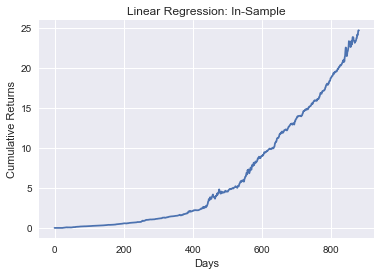

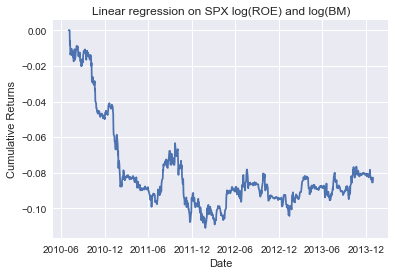

Fitting Bagging Regressor model 

In-sample: CAGR=1.4881 Sharpe ratio=5.38915 maxDD=-0.0892212 maxDDD=29 Calmar ratio=16.6788
Out-of-sample: CAGR=-0.00262873 Sharpe ratio=-0.0555341 maxDD=-0.0677227 maxDDD=764 Calmar ratio=-0.038816


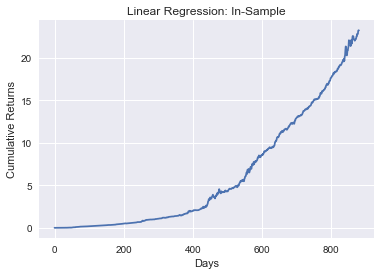

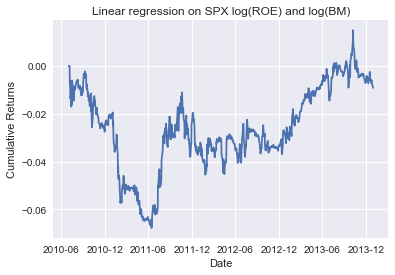

In [37]:
for index, row in resultDF.iterrows():
    name=row[0]
    model= models[row[0]]
    params=literal_eval(row[1])
    trading(name,model,params)

In [38]:
tradingDF

,model,In_CAGR,In_Sharpe_Ratio,In_maxDD,In_maxDDD,In_Calmar_Ratio,Out_CAGR,Out_Sharpe_Ratio,Out_maxDD,Out_maxDDD,Out_Calmar_Ratio
0,Random Forest,0.00210846,0.16167,-0.528619,685,0.00398862,0.250752,1.31507,-0.216898,171,1.15609
1,Lasso Regression,0.00210846,0.16167,-0.528619,685,0.00398862,0.250752,1.31507,-0.216898,171,1.15609
2,Linear Regression,0.0495108,0.334931,-0.323853,447,0.152881,0.10437,0.982639,-0.139648,413,0.747375
3,Gradient Boosting,0.00402664,0.167588,-0.525453,685,0.00766319,0.250468,1.31419,-0.216898,171,1.15477
4,Decision Tree,0.00210846,0.16167,-0.528619,685,0.00398862,0.250752,1.31507,-0.216898,171,1.15609
5,Ada Boosting,0.00210846,0.16167,-0.528619,685,0.00398862,0.250752,1.31507,-0.216898,171,1.15609
6,Extra Tree Regressor,1.53071,5.3234,-0.102167,29,14.9824,-0.0244049,-0.69275,-0.110957,879,-0.21995
7,Bagging Regressor,1.4881,5.38915,-0.0892212,29,16.6788,-0.00262873,-0.0555341,-0.0677227,764,-0.038816


## Multi Factor Model

In [39]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import functions as fn
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
pd.set_option('display.max_rows', 16)
sns.set()

#Loading .mat file
mat = loadmat('fundamentalData.mat')
indQT = ['ARQ_'+e[0] for e in mat.pop('indQ').squeeze()] + ['ART_'+e[0] for e in mat.pop('indT').squeeze()]
syms = [e[0] for e in mat.pop('syms').squeeze()]
dates = pd.DatetimeIndex(mat.pop('tday').astype(str).squeeze())
df_list = [pd.DataFrame(mat.pop(i)) for i in indQT]
mid = pd.DataFrame(mat.pop('mid'))
del mat

holdingDays = 252 // 4; #hold a quarter
#Returns and Normalization
Ret1 = fn.calculateReturns(mid.copy(), 1)
#Vol1 = Ret1.copy().abs().rolling(window=252).mean() # daily returns volatility
RetQ = fn.calculateReturns(mid.copy(), holdingDays) #quarterly return

#shifted next quarter's return to today's row to use as response variable. 
#Can enter only at next day's close. Normalized by volatility.
#RetFut = RetQ.copy().shift(-(holdingDays+1)).divide(Vol1)
RetFut = RetQ.copy().shift(-(holdingDays+1))

del mid

#############################
m = Ret1.shape[0]
trainSize = m // 2
testSize = m - trainSize
#############################

Ret1train = Ret1[:trainSize]
Ret1test = Ret1[trainSize:]

del Ret1, RetQ

#flattening and repetition of the date vector
flat_train = RetFut[:trainSize].size
flat_test = RetFut[trainSize:].size
m0 = RetFut.shape[0] #original number of observations
nStocks = RetFut.shape[1] #original number of stocks

datesTrain = dates.values[:trainSize].flatten()
datesTest = dates.values[trainSize:].flatten()

del dates

#number of indices ARQ_* and ART_* (# of features)
nInd = len(indQT)

Y0train = RetFut.values[:trainSize].flatten()[:,np.newaxis]
Y0test = RetFut.values[trainSize:].flatten()[:,np.newaxis]

X0train = np.zeros((flat_train, nInd))
X0test = np.zeros((flat_test, nInd))
n = 0
for df in df_list:
    df = df.values
    X0train[:, n] = df[:trainSize].flatten()
    X0test[:, n] = df[trainSize:].flatten()
    n += 1

del df_list, RetFut

dataCleanTrain = pd.DataFrame(np.hstack([X0train, Y0train])).dropna(how='any', axis=0)
dataCleanTest = pd.DataFrame(np.hstack([X0test, Y0test])).dropna(how='any', axis=0)

ixCleanTrain = dataCleanTrain.index.values
ixCleanTest = dataCleanTest.index.values

dataCleanTrain = dataCleanTrain.values
dataCleanTest = dataCleanTest.values

Xtrain, ytrain = dataCleanTrain[:, 0:-1], dataCleanTrain[:, -1][:,np.newaxis]
Xtest, ytest = dataCleanTest[:, 0:-1], dataCleanTest[:, -1][:,np.newaxis]

del dataCleanTrain, dataCleanTest

In [40]:
df_idx = 0

In [41]:
for name, m in models.items():
    print ("Fitting " + name + " model \n")
    crossValidate(name, m, pd.DataFrame(Xtrain), pd.DataFrame(ytrain), 'default')

Fitting Linear Regression model 

Fold 1 Training accuracy: 0.04347561301788838
Fold 1 Validation accuracy: -0.20756748607442543
Fold 2 Training accuracy: 0.04010759085942717
Fold 2 Validation accuracy: -0.16933993464022512
Fold 3 Training accuracy: 0.041161339721903056
Fold 3 Validation accuracy: -0.09974922820648557
Fold 4 Training accuracy: 0.03693987030319201
Fold 4 Validation accuracy: -0.8242526075890031
Fold 5 Training accuracy: 0.05328018855160477
Fold 5 Validation accuracy: -0.6922591087767864
Fold 6 Training accuracy: 0.021920342766053147
Fold 6 Validation accuracy: -0.5851783351174649
Fold 7 Training accuracy: 0.028476090267485876
Fold 7 Validation accuracy: -0.3334534395005684
Fold 8 Training accuracy: 0.04237933274890804
Fold 8 Validation accuracy: -2.092270046427803
Fold 9 Training accuracy: 0.03751531734390512
Fold 9 Validation accuracy: -0.06301870729013781
Fold 10 Training accuracy: 0.041366850957318624
Fold 10 Validation accuracy: -0.34468790694936247


Mean r2 score 

Fold 8 Training accuracy: 0.8504270102695682
Fold 8 Validation accuracy: -0.2724443789275046
Fold 9 Training accuracy: 0.8652707087864484
Fold 9 Validation accuracy: -0.17393607214326123
Fold 10 Training accuracy: 0.8577589094530419
Fold 10 Validation accuracy: -0.42363740361450364


Mean r2 score for Validation data: -0.3993589449526354
Standard Deviation for Validation data: 0.25973536006311604




In [42]:
resultDF = resultDF.sort_values('test_acc',ascending=False)#.reset_index(drop=True)
resultDF.groupby('model').first().sort_values('test_acc',ascending=False)

,hyperparams,train_acc,train_std,test_acc,test_std
model,,,,,
Random Forest,default,0.035390,0.007912,-0.308102,0.282678
Lasso Regression,default,0.000000,0.000000,-0.309389,0.292835
Gradient Boosting,default,0.081158,0.016250,-0.340467,0.283016
Ada Boosting,default,0.152528,0.037776,-0.347246,0.294283
Decision Tree,default,0.116666,0.023339,-0.372207,0.287662
Extra Tree Regressor,default,0.858432,0.006499,-0.399359,0.259735
Bagging Regressor,default,0.859600,0.004115,-0.463296,0.268750
Linear Regression,default,0.038662,0.008091,-0.541178,0.571454


In [43]:
df_idx = 0

In [44]:
for name in models.keys():
    gridSearch(name, models, param_grids, pd.DataFrame(Xtrain), pd.DataFrame(ytrain))

Fitting Linear Regression model 

Fold 1 Training accuracy: 0.04347561301788838
Fold 1 Validation accuracy: -0.20756748607442543
Fold 2 Training accuracy: 0.04010759085942717
Fold 2 Validation accuracy: -0.16933993464022512
Fold 3 Training accuracy: 0.041161339721903056
Fold 3 Validation accuracy: -0.09974922820648557
Fold 4 Training accuracy: 0.03693987030319201
Fold 4 Validation accuracy: -0.8242526075890031
Fold 5 Training accuracy: 0.05328018855160477
Fold 5 Validation accuracy: -0.6922591087767864
Fold 6 Training accuracy: 0.021920342766053147
Fold 6 Validation accuracy: -0.5851783351174649
Fold 7 Training accuracy: 0.028476090267485876
Fold 7 Validation accuracy: -0.3334534395005684
Fold 8 Training accuracy: 0.04237933274890804
Fold 8 Validation accuracy: -2.092270046427803
Fold 9 Training accuracy: 0.03751531734390512
Fold 9 Validation accuracy: -0.06301870729013781
Fold 10 Training accuracy: 0.041366850957318624
Fold 10 Validation accuracy: -0.34468790694936247


Mean r2 score 

Fold 8 Training accuracy: 0.8557323233456592
Fold 8 Validation accuracy: -0.3000435367779746
Fold 9 Training accuracy: 0.8577574056495811
Fold 9 Validation accuracy: -0.23493723024034985
Fold 10 Training accuracy: 0.8516011780939148
Fold 10 Validation accuracy: -0.26407316514988866


Mean r2 score for Validation data: -0.4110136149441205
Standard Deviation for Validation data: 0.2816194798676181




In [45]:
resultDF = resultDF.sort_values('test_acc',ascending=False)#.reset_index(drop=True)
resultDF.groupby('model').first().sort_values('test_acc',ascending=False)

,hyperparams,train_acc,train_std,test_acc,test_std
model,,,,,
Random Forest,"{'bootstrap': True, 'max_depth': 1, 'max_featu...",0.037229,0.009683,-0.305795,0.285913
Lasso Regression,"{'alpha': 0.7, 'normalize': True}",0.000000,0.000000,-0.309389,0.292835
Decision Tree,"{'max_depth': 1, 'max_features': 'log2'}",0.023704,0.008975,-0.332285,0.285566
Gradient Boosting,"{'alpha': 0.8, 'learning_rate': 0.05, 'max_dep...",0.079981,0.016195,-0.336752,0.279248
Ada Boosting,"{'learning_rate': 0.1, 'n_estimators': 50}",0.154409,0.038954,-0.349338,0.288359
Extra Tree Regressor,"{'bootstrap': True, 'n_estimators': 40}",0.857846,0.005107,-0.411014,0.281619
Bagging Regressor,"{'bootstrap': True, 'n_estimators': 40}",0.859409,0.005578,-0.434173,0.272756
Linear Regression,{'normalize': True},0.038662,0.008091,-0.541178,0.571454


In [46]:
df_idx=0

In [47]:
def trading_multi(name, model, hyperparams='default'):
    
    global df_idx
    print ("Fitting " + name + " model \n")

        # Update model hyperparameters if given
    if hyperparams is not 'default':
        model.set_params(**hyperparams)
    model.fit(Xtrain, ytrain)

    # print( ('Number of observations: {:d}').format(trainSize))
    # print(('Coefficients:\nIntercept={}').format(linreg_model.intercept_))
    # n = 1
    # for e in linreg_model.coef_.squeeze():
    #     print(('x{:2d} = {:.4e}').format(n, e))
    #     n += 1

    # print(('R-squared = {}').format(linreg_model.score(Xtrain, ytrain)))

    # Make "predictions" based on model on training set, reshape back to original matrix dimensions
    Ypred = model.predict(Xtrain)

    # print(('Root Mean Squared Error = {:.4f}').format(np.sqrt(mean_squared_error(ytrain, Ypred))))
    Ypred=Ypred.reshape(3363,1) ######################################################################

  
    retPred = np.nan * np.empty((Ret1train.size, 1))
    retPred[ixCleanTrain] = Ypred
    retPred = retPred.reshape(Ret1train.shape)

    longs = pd.DataFrame((retPred>0).astype(int)).shift(1) #1 day later
    shorts = pd.DataFrame((retPred<0).astype(int)).shift(1)
    longs.loc[0] = 0
    shorts.loc[0] = 0

    positions = np.zeros(retPred.shape)
    for h in range(holdingDays):
        long_lag = longs.shift(h)
        long_lag.fillna(value=0, inplace=True)
        long_lag = long_lag.astype(bool).values

        short_lag = shorts.shift(h)
        short_lag.fillna(value=0, inplace=True)
        short_lag = short_lag.astype(bool).values

        positions[long_lag] += 1
        positions[short_lag] -= 1

    dRetA = np.sum(np.multiply(pd.DataFrame(positions).shift(1).fillna(0).values.squeeze(), Ret1train.fillna(0).values), axis=1)
    dRetB = np.sum(pd.DataFrame(positions).shift(1).abs().values.squeeze(), axis=1)

    dailyRet = np.divide(dRetA, dRetB)
    dailyRet[~np.isfinite(dailyRet)] = 0
    cumret = np.cumprod(1 + dailyRet) - 1

    plt.figure(1)
    plt.plot(range(trainSize), cumret)
    plt.title('Linear Regression: In-Sample')
    plt.ylabel('Cumulative Returns')
    plt.xlabel('Days')

    cagr = (1 + cumret[-1]) ** (252 / trainSize) - 1
    maxDD, maxDDD, _ = fn.calculateMaxDD(cumret)
    ratio = (252.0 ** 0.5) * np.mean(dailyRet) / np.std(dailyRet)
    print(('In-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}'\
    ).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD))

    tradingDF.loc[df_idx, 'model'] = name
    tradingDF.loc[df_idx, 'In_CAGR'] = cagr
    tradingDF.loc[df_idx, 'In_Sharpe_Ratio'] = ratio
    tradingDF.loc[df_idx, 'In_maxDD'] = maxDD
    tradingDF.loc[df_idx, 'In_maxDDD'] = maxDDD.astype(int)
    tradingDF.loc[df_idx, 'In_Calmar_Ratio'] = -cagr/maxDD
    
    ##################################################################

    # Make real predictions on test (out-of-sample)
    Ypred = model.predict(Xtest)
    Ypred=Ypred.reshape(3953,1) ######################################################################

    # print(('Root Mean Squared Error = {:.4f}').format(np.sqrt(mean_squared_error(ytest, Ypred))))

    retPred = np.nan * np.empty((Ret1test.size, 1))
    retPred[ixCleanTest] = Ypred
    retPred = retPred.reshape(Ret1test.shape)

    longs = pd.DataFrame((retPred>0).astype(int)).shift(1) #1 day later
    shorts = pd.DataFrame((retPred<0).astype(int)).shift(1)
    longs.loc[0] = 0
    shorts.loc[0] = 0

    positions = np.zeros(retPred.shape)
    for h in range(holdingDays):
        long_lag = longs.shift(h)
        long_lag.fillna(value=0, inplace=True)
        long_lag = long_lag.astype(bool).values

        short_lag = shorts.shift(h)
        short_lag.fillna(value=0, inplace=True)
        short_lag = short_lag.astype(bool).values

        positions[long_lag] += 1
        positions[short_lag] -= 1

    dRetA = np.sum(np.multiply(pd.DataFrame(positions).shift(1).fillna(0).values.squeeze(), Ret1test.fillna(0).values), axis=1)
    dRetB = np.sum(pd.DataFrame(positions).shift(1).abs().values.squeeze(), axis=1)

    dailyRet = np.divide(dRetA, dRetB)
    dailyRet[~np.isfinite(dailyRet)] = 0
    cumret = np.cumprod(1 + dailyRet) - 1

    plt.figure(2)
    plt.plot(datesTest, cumret)
    plt.title('Linear regression on SPX fundamental facotrs')
    plt.ylabel('Cumulative Returns')
    plt.xlabel('Date')

    cagr = (1 + cumret[-1]) ** (252 / testSize) - 1
    maxDD, maxDDD, _ = fn.calculateMaxDD(cumret)
    ratio = (252.0 ** 0.5) * np.mean(dailyRet) / np.std(dailyRet)
    print(('Out-of-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}'\
    ).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD))
    
    tradingDF.loc[df_idx, 'Out_CAGR'] = cagr
    tradingDF.loc[df_idx, 'Out_Sharpe_Ratio'] = ratio
    tradingDF.loc[df_idx, 'Out_maxDD'] = maxDD
    tradingDF.loc[df_idx, 'Out_maxDDD'] = maxDDD.astype(int)
    tradingDF.loc[df_idx, 'Out_Calmar_Ratio'] = -cagr/maxDD
    df_idx += 1
    plt.show()

Fitting Random Forest model 

In-sample: CAGR=0.00067066 Sharpe ratio=0.147289 maxDD=-0.51953 maxDDD=668 Calmar ratio=0.0012909
Out-of-sample: CAGR=0.240245 Sharpe ratio=1.29487 maxDD=-0.218969 maxDDD=154 Calmar ratio=1.09717


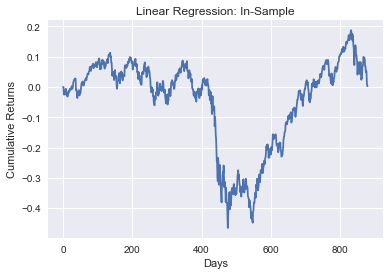

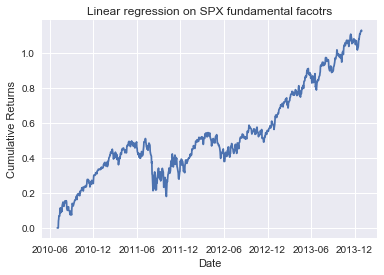

Fitting Lasso Regression model 

In-sample: CAGR=0.00067066 Sharpe ratio=0.147289 maxDD=-0.51953 maxDDD=668 Calmar ratio=0.0012909
Out-of-sample: CAGR=0.240245 Sharpe ratio=1.29487 maxDD=-0.218969 maxDDD=154 Calmar ratio=1.09717


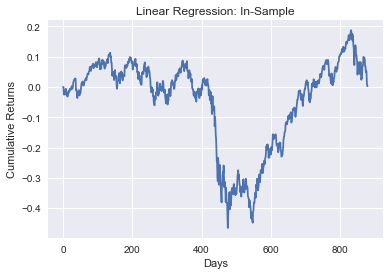

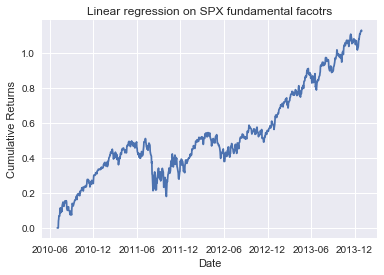

Fitting Decision Tree model 

In-sample: CAGR=0.00067066 Sharpe ratio=0.147289 maxDD=-0.51953 maxDDD=668 Calmar ratio=0.0012909
Out-of-sample: CAGR=0.240245 Sharpe ratio=1.29487 maxDD=-0.218969 maxDDD=154 Calmar ratio=1.09717


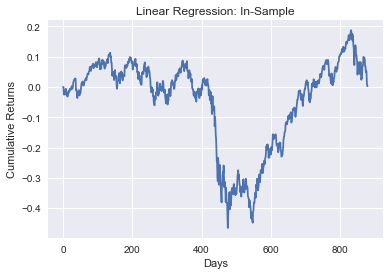

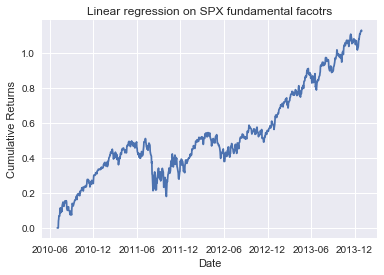

Fitting Gradient Boosting model 

In-sample: CAGR=0.0901975 Sharpe ratio=0.612891 maxDD=-0.210035 maxDDD=569 Calmar ratio=0.429441
Out-of-sample: CAGR=0.0890207 Sharpe ratio=1.75404 maxDD=-0.0503143 maxDDD=210 Calmar ratio=1.76929


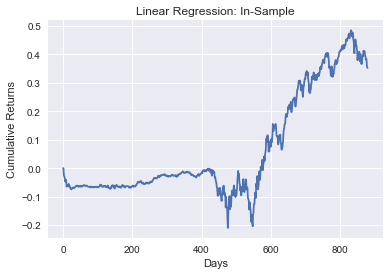

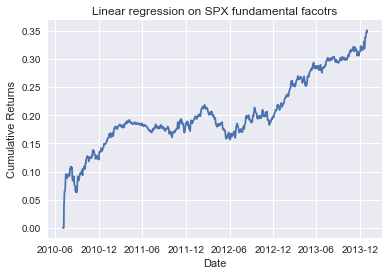

Fitting Ada Boosting model 

In-sample: CAGR=0.0732919 Sharpe ratio=0.641256 maxDD=-0.143664 maxDDD=436 Calmar ratio=0.51016
Out-of-sample: CAGR=-0.0784245 Sharpe ratio=-1.24009 maxDD=-0.250148 maxDDD=879 Calmar ratio=-0.313513


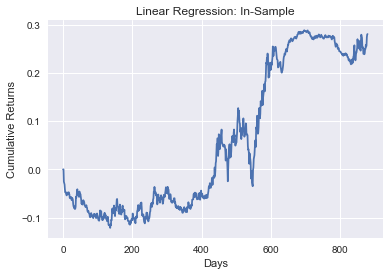

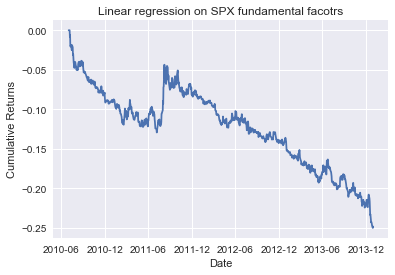

Fitting Extra Tree Regressor model 

In-sample: CAGR=0.716015 Sharpe ratio=2.9489 maxDD=-0.145724 maxDDD=64 Calmar ratio=4.9135
Out-of-sample: CAGR=-0.00877366 Sharpe ratio=-0.270857 maxDD=-0.0546774 maxDDD=476 Calmar ratio=-0.160462


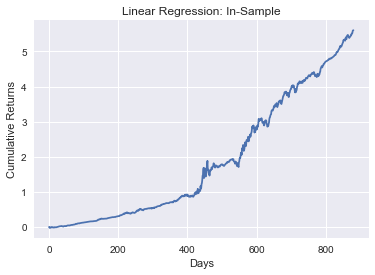

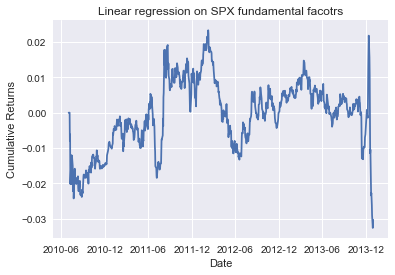

Fitting Bagging Regressor model 

In-sample: CAGR=0.726198 Sharpe ratio=3.04615 maxDD=-0.142194 maxDDD=64 Calmar ratio=5.10708
Out-of-sample: CAGR=0.00287505 Sharpe ratio=0.105739 maxDD=-0.0347144 maxDDD=341 Calmar ratio=0.0828202


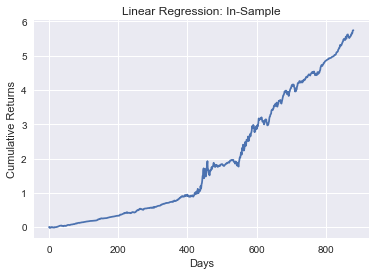

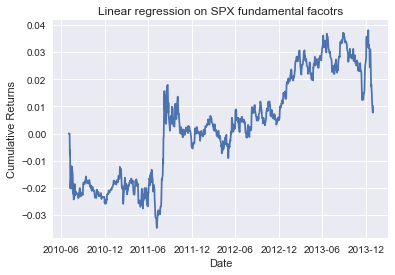

Fitting Linear Regression model 

In-sample: CAGR=0.0500292 Sharpe ratio=0.381315 maxDD=-0.283635 maxDDD=604 Calmar ratio=0.176386
Out-of-sample: CAGR=0.144136 Sharpe ratio=1.66236 maxDD=-0.0883385 maxDDD=168 Calmar ratio=1.63163


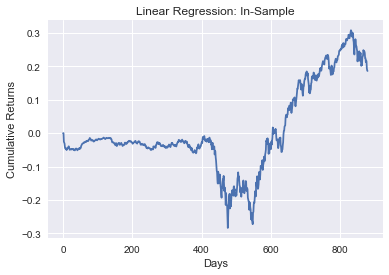

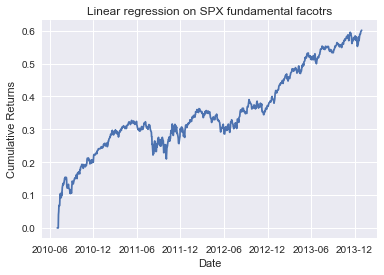

In [48]:
for index, row in resultDF.iterrows():
    name=row[0]
    model= models[row[0]]
    params=literal_eval(row[1])
    trading_multi(name,model,params)

In [49]:
tradingDF

,model,In_CAGR,In_Sharpe_Ratio,In_maxDD,In_maxDDD,In_Calmar_Ratio,Out_CAGR,Out_Sharpe_Ratio,Out_maxDD,Out_maxDDD,Out_Calmar_Ratio
0,Random Forest,0.00067066,0.147289,-0.51953,668,0.0012909,0.240245,1.29487,-0.218969,154,1.09717
1,Lasso Regression,0.00067066,0.147289,-0.51953,668,0.0012909,0.240245,1.29487,-0.218969,154,1.09717
2,Decision Tree,0.00067066,0.147289,-0.51953,668,0.0012909,0.240245,1.29487,-0.218969,154,1.09717
3,Gradient Boosting,0.0901975,0.612891,-0.210035,569,0.429441,0.0890207,1.75404,-0.0503143,210,1.76929
4,Ada Boosting,0.0732919,0.641256,-0.143664,436,0.51016,-0.0784245,-1.24009,-0.250148,879,-0.313513
5,Extra Tree Regressor,0.716015,2.9489,-0.145724,64,4.9135,-0.00877366,-0.270857,-0.0546774,476,-0.160462
6,Bagging Regressor,0.726198,3.04615,-0.142194,64,5.10708,0.00287505,0.105739,-0.0347144,341,0.0828202
7,Linear Regression,0.0500292,0.381315,-0.283635,604,0.176386,0.144136,1.66236,-0.0883385,168,1.63163


## Factor Loadings

In [50]:
rfr = LinearRegression(normalize=True)
rfr.fit(Xtrain, ytrain)
# Make "predictions" based on model on training set, reshape back to original matrix dimensions
#Ypred = rfr.predict(Xtrain)
# Make real predictions on test (out-of-sample)
Ypred = rfr.predict(Xtest)
Ypred=Ypred.reshape(3953,1) ######################################################################


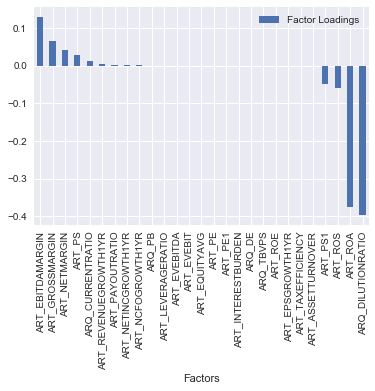

In [51]:
#Get the regeression coefficients and the intercept of the Multi factor model
df1 = pd.DataFrame({'Factors': indQT, 'Factor Loadings': (rfr.coef_[0])})
df1 = df1.sort_values('Factor Loadings',ascending=False).set_index('Factors')
df1.plot.bar()

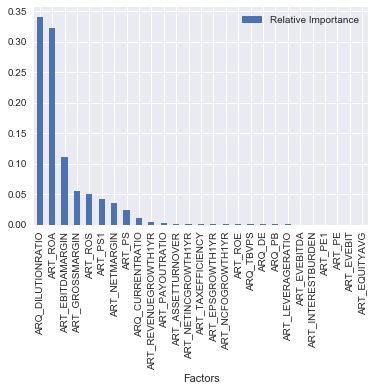

In [52]:
#Computing Relative Importance of Each factor
df2= pd.DataFrame({'Factors': indQT, 'Relative Importance': abs(rfr.coef_[0])/sum(abs(rfr.coef_[0]))})
df2 = df2.sort_values('Relative Importance',ascending=False).set_index('Factors')
df2.plot.bar()